# Alzheimer Classifiaction
In this project a Neural Network will be used to classify different stages of the Alzheimer's Disease, using MRI Pictures.
Someone who wants to clone the project can choose between two datasets, one from Kaggle (https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images), and the well known ADNI Dataset (Alzheimer's Disease Neuroimaging Initiative: https://adni.loni.usc.edu/).

A very nice paper on Diagnosis of Alzheimer's is Classification and Visualization of Alzheimer’s Disease using Volumetric Convolutional Neural Network and Transfer Learning (https://www.nature.com/articles/s41598-019-54548-6). I will use a similar approach using transfer learning, but skip the step of using a volumetric convolutional neural network because that would need a lot more training data. For now I won't use an Inception network either.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder


from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from IPython.display import clear_output
import os

from src.model import *
from src.utils import *
from src.train import *

models_path = './models'
dataset_path = "./reduction"
if not os.path.exists(models_path):
    os.makedirs(models_path)

Perform data augmentation and take a look at the dimensions of the data

In [2]:
#data augmentation and preprocessing
transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.CenterCrop(256),transforms.ToTensor(), transforms.Normalize(mean=[0.1784,0.1784, 0.1784], std=[0.2025,0.2025, 0.2025]) ])

alz_dataset = ImageFolder(os.path.join(dataset_path, "train"), transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(alz_dataset, ( round(len(alz_dataset)*0.9), round(len(alz_dataset)*0.1) ))

second = ImageFolder(os.path.join("Alzheimers-ADNI", "train"), transform=transform)
s_train_dataset, s_val_dataset = torch.utils.data.random_split(alz_dataset, ( round(len(alz_dataset)*0.9), round(len(alz_dataset)*0.1) ))

#Datasets we are going to be working with
datasets = {'train': train_dataset, 'val': val_dataset}
s_datasets = {'train': s_train_dataset, 'val': s_val_dataset}
test_dataset = ImageFolder(os.path.join(dataset_path, "test"), transform=transform)

#Output some infos about the data and datasets
print("Training data lenght: ", len(datasets["train"]))
print("Test data lenght: ", len(datasets["train"]))
print("Dimensions of an image: ", datasets["train"][0][0].shape)

Training data lenght:  576
Test data lenght:  576
Dimensions of an image:  torch.Size([3, 256, 256])


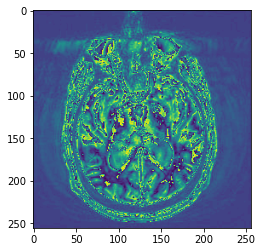

In [3]:
plt.imshow(transforms.ToPILImage()(alz_dataset[1][0][0]))

# Take a look at the data, classes
There are 5 classes of patients:
- Alzheimer's Disease
- Early Mild Cognitive Impairment
- Late Mild Cognitive Impairment
- Mild Cognitive Impairment
- Control Normals

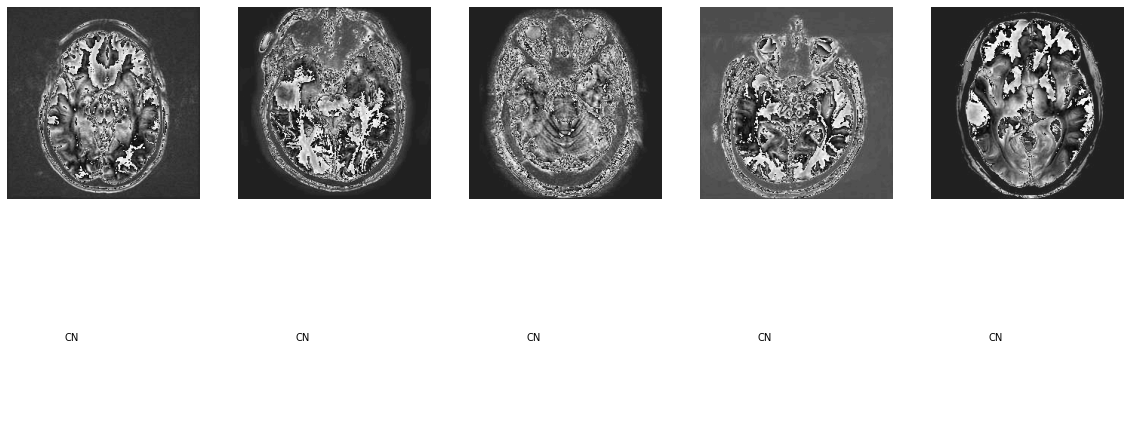

In [4]:
show_examples(datasets["train"])

# Preparing some parameters for the training and evaluation process
We have to set following things in a configuration file, so at a later point we can use raytune for Hyperparameter search:

In [5]:
config = {"batch_size":8, "lr":1e-3}

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=config["batch_size"], shuffle=True, num_workers=8, drop_last=True) for x in ['train', 'val']}
s_dataloaders = {x: torch.utils.data.DataLoader(s_datasets[x], batch_size=config["batch_size"], shuffle=True, num_workers=8, drop_last=True) for x in ['train', 'val']}
test_loader =torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=8, drop_last=False)

# The model
The approach is simple: First a Convolutional autoencoder is trained to encode and decode the images, than the encoder part which gained a good performance in extracting the features from MRI's is saved and transferred to be used in combination with
2 linear layers which will do the classification. In the second step only these two last layers will be trained.

In [7]:
autoencoder = ResAE()

In [8]:
classifier = AlzheimerClassifier(hparams= {"classes": 2})

#### Move everything to the GPU if possible 

In [9]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        autoencoder = nn.DataParallel(autoencoder)
        classifier = nn.DataParallel(classifier)
autoencoder.to(device)
classifier.to(device)

clear_output()

#### Optimizers
At this point only Adam will be used, no fancy stuff

In [10]:
#Autoencoder
optim_a = torch.optim.Adam(autoencoder.parameters(), lr = 1e-3)
#Classifier
optim_b = torch.optim.Adam(classifier.parameters(), lr = 1e-3)

#### Loss functions
For the autoencoder the usual MSE Loss will be used, for the classifier (clearly) the Cross Entropy

In [11]:
#Autoencoder
loss_a = nn.MSELoss()
#Classifier
loss_b = nn.CrossEntropyLoss()

##### Use a learning rate scheduler

In [12]:
lambda_a = lambda epoch: 0.9 ** epoch
scheduler_a = torch.optim.lr_scheduler.LambdaLR(optim_a, lr_lambda=lambda_a)
scheduler_b =  torch.optim.lr_scheduler.LambdaLR(optim_b, lr_lambda=lambda_a)

### Lets train the Autoencoder
Of course we have to keep track of the whole progress using Tensorboard, and use self-defined callbacks like early stopping and occasional saving if the model performs well.

In [14]:
autoencoder = train_autoencoder(autoencoder, s_dataloaders,loss_a, optim_a, scheduler_a, device,  num_epochs=50, early_stop=5)

Epoch 19/49
train loss: 0.0892


 38%|█████████████████████████████▎                                               | 19/50 [3:05:21<5:02:25, 585.35s/it]


KeyboardInterrupt: 

Test the autoencoder

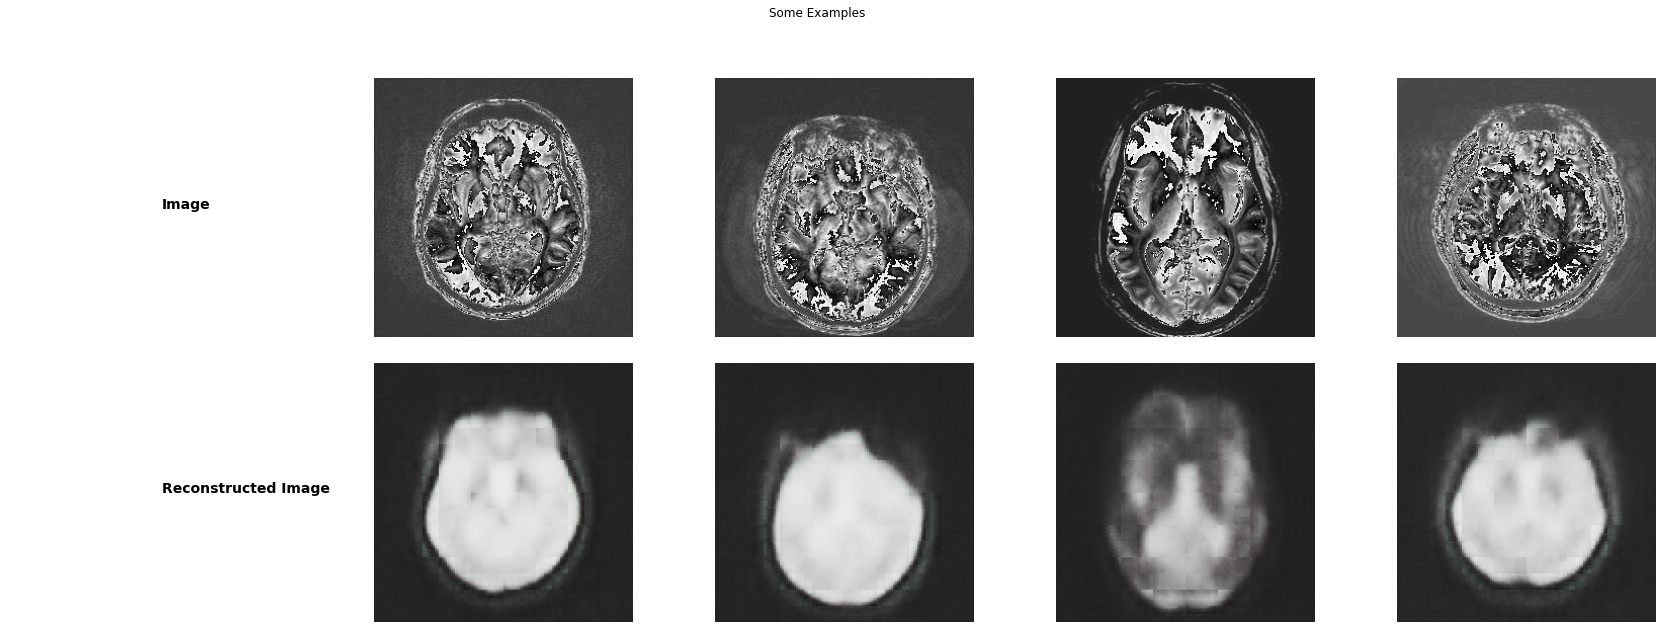

In [18]:
show_ae_results(test_loader, autoencoder)

#### Train the Classifier

In [13]:
autoencoder.load_state_dict(torch.load(os.path.join(models_path, "autoencoder.pth")))

<All keys matched successfully>

In [14]:
torch.save(autoencoder.encoder.state_dict(), os.path.join(models_path, "encoder.pth"))

In [15]:
classifier.encoder.load_state_dict(torch.load(os.path.join(models_path, "encoder.pth")))

<All keys matched successfully>

In [ ]:
classifier = train_classifier(classifier, dataloaders,loss_b, optim_b, scheduler_b, device,  num_epochs=50, early_stop=5)

Epoch 2/49


Acurracy:  76.99115044247787 %


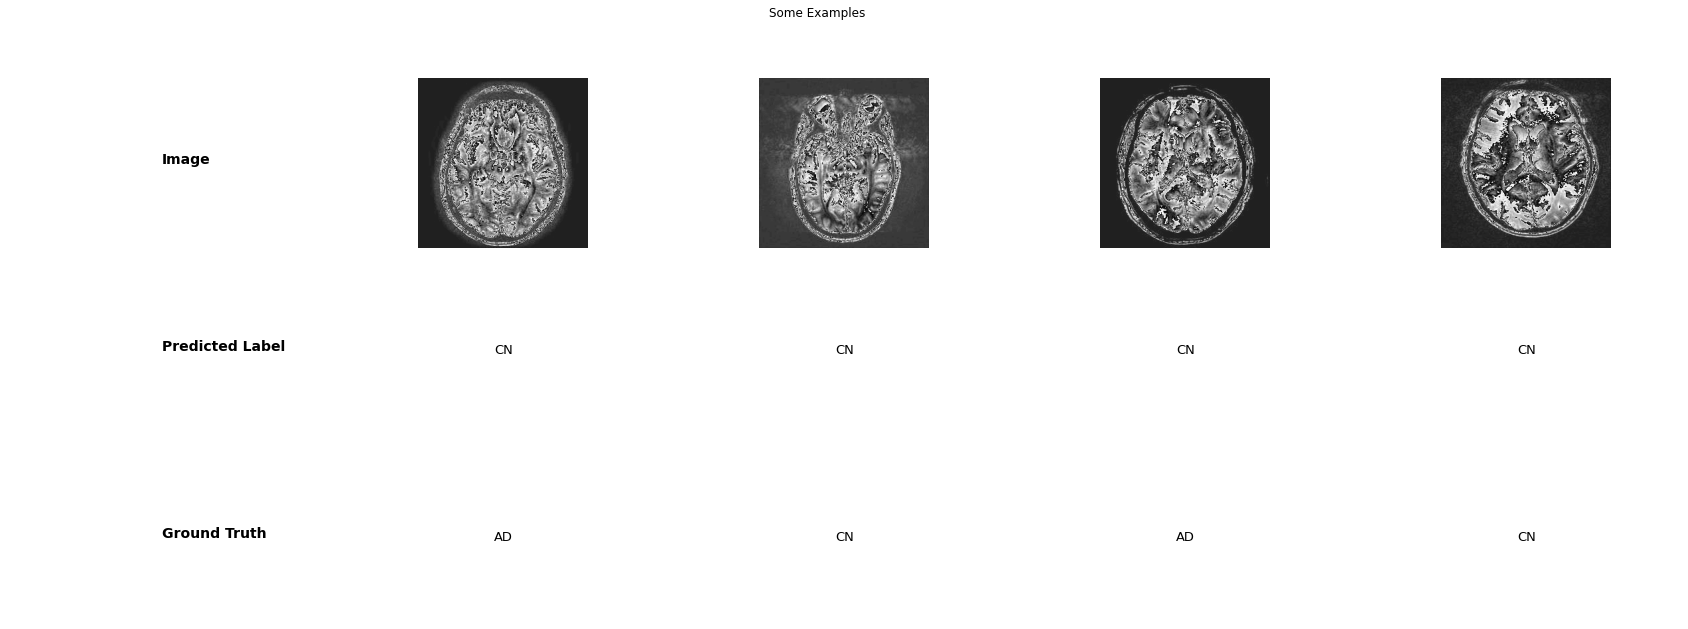

In [33]:
#Testing the model
classifier.to("cpu")
classifier.load_state_dict(torch.load("./models/classifier.pth"))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)
test_model(test_loader, classifier)
print("Acurracy: ", test_acurracy(test_loader, classifier)*100, "%")